In [1]:
# Mount google drive
from google.colab import drive
ROOT = "/content/drive"
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install datasets
!pip install deepspeed
!pip install sentencepiece

In [3]:
from transformers import AutoModel, DebertaV2TokenizerFast
import sentencepiece
import torch
import numpy as np
import matplotlib.pyplot as plt
import re

In [4]:
%cd drive/MyDrive/Repos/llm-sparsification-cvf/

/content/drive/MyDrive/Repos/llm-sparsification-cvf


In [31]:
from src.exploration_utils import deberta_layer_analysis, collect_params, plot_weight_distro, \
plot_weights_across_layers, weight_size_distro

In [6]:
%load_ext autoreload

In [7]:
%autoreload 2

In [8]:
tokenizer = DebertaV2TokenizerFast.from_pretrained('microsoft/deberta-v2-xxlarge')
# model = Deberta.from_pretrained('microsoft/deberta-v2-xxlarge')

model = AutoModel.from_pretrained("microsoft/deberta-v2-xxlarge")
# tokenizer = DebertaV2Tokenizer.from_pretrained("hf-internal-testing/tiny-random-deberta-v2")
# model = DebertaV2ForSequenceClassification.from_pretrained("hf-internal-testing/tiny-random-deberta-v2")


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/633 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v2-xxlarge were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

In [10]:
params = model.state_dict() 

In [11]:
len(params.keys())

779



## DeBERTaXXL Architecture
Vocabulary size: 128k
<br>
Backbone params: 1320
<br>
Hidden size: 1536
<br>
Each of the 48 layers of DeBERTa consists of:
<br>
#### DisentangledSelfAttention
'key/query/values' # [each 1536 dims]
<br>
'Linear layer# [1536]'
<br>
'Layer Norm [1536]'
<br>
#### Intermediate
Linear layer with a GELU activation [1536 to 6144 dims]

#### Output
Linear Layer [6144 dims to 1436]
<br>
LayerNorm [1536]




In [12]:
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")

Total Parameters: 1564549632


In [ ]:
params.keys()

In [14]:
bins_labs = ["0 to 1E-06", "1E-06 to 1E-05", "1E-05 to 1E-04", "1E-04 to 1E-03",
             "1E-03 to 1E-02", "1E-02 to 1E-01", "1E-01 to 1", "1 to 10"]

### Overall analysis

In [15]:
non_embed_param_names = list(params.keys())
non_embed_param_names.remove('embeddings.position_ids')
non_embed_param_names.remove('embeddings.word_embeddings.weight')
non_embed_param_names.remove('embeddings.LayerNorm.weight')
non_embed_param_names.remove('embeddings.LayerNorm.bias')
non_embed_param_names.remove('encoder.rel_embeddings.weight')

all_layers = collect_params(params, non_embed_param_names)

encoder.layer.0.attention.self.query_proj.weight
encoder.layer.0.attention.self.query_proj.bias
encoder.layer.0.attention.self.key_proj.weight
encoder.layer.0.attention.self.key_proj.bias
encoder.layer.0.attention.self.value_proj.weight
encoder.layer.0.attention.self.value_proj.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query_proj.weight
encoder.layer.1.attention.self.query_proj.bias
encoder.layer.1.attention.self.key_proj.weight
encoder.layer.1.attention.self.key_proj.bias
encoder.layer.1.attention.self.value_proj.weight
encoder.layer.1.attention.self.value_proj.bias
encoder.layer.

In [16]:
len(non_embed_param_names)

774

In [17]:
all_layers.shape

torch.Size([1366998528])

In [22]:
cnts_all, pcts_all = weight_size_distro(all_layers)

In [23]:
pcts_all

array([2.61207304e-05, 2.38935883e-04, 2.37566240e-03, 2.37610431e-02,
       2.30671111e-01, 7.36004804e-01, 6.91759779e-03, 4.72568175e-06])

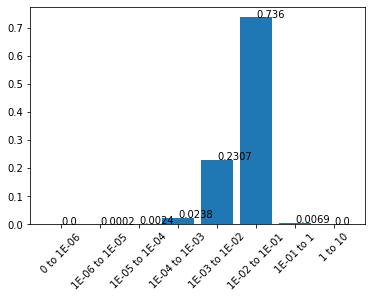

In [24]:
plot_weight_distro(bins_labs, pcts_all)

The plot above shows that 73.6% of the 1.3 billion non-embedding parameters in DeBERTA-xxl have an absolute value between .001 and .01. A further 23% of parameters are between .0001 and .001. Half of the remaining ~4% of weights are between .00001 and .0001

### Layer by layer analysis

encoder.layer.0.attention.self.query_proj.weight
encoder.layer.0.attention.self.query_proj.bias
encoder.layer.0.attention.self.key_proj.weight
encoder.layer.0.attention.self.key_proj.bias
encoder.layer.0.attention.self.value_proj.weight
encoder.layer.0.attention.self.value_proj.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query_proj.weight
encoder.layer.1.attention.self.query_proj.bias
encoder.layer.1.attention.self.key_proj.weight
encoder.layer.1.attention.self.key_proj.bias
encoder.layer.1.attention.self.value_proj.weight
encoder.layer.1.attention.self.value_proj.bias
encoder.layer.

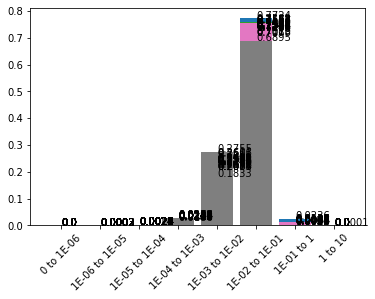

In [32]:
layer_results = np.empty((48,9))
for layer_num in range(48):
    cnts, pcts = deberta_layer_analysis(layer_num, params)
    layer_results[layer_num, 0] = layer_num
    layer_results[layer_num, 1:] = pcts

In [33]:
import pandas as pd
layer_results = pd.DataFrame(layer_results)

In [34]:
colnames = ['layer_num']
colnames.extend(bins_labs)

In [35]:
layer_results.columns = colnames

In [36]:
layer_results.head()

,layer_num,0 to 1E-06,1E-06 to 1E-05,1E-05 to 1E-04,1E-04 to 1E-03,1E-03 to 1E-02,1E-02 to 1E-01,1E-01 to 1,1 to 10
0,0.0,0.000021,0.000192,0.001858,0.018618,0.183346,0.772357,0.023555,5.273279e-05
1,1.0,0.000022,0.000211,0.002112,0.021243,0.207667,0.758297,0.010447,5.647420e-07
2,2.0,0.000023,0.000213,0.002129,0.021280,0.208626,0.757846,0.009883,1.058891e-07
3,3.0,0.000025,0.000223,0.002232,0.022212,0.216584,0.750446,0.008278,3.529638e-08
4,4.0,0.000026,0.000225,0.002261,0.022629,0.220186,0.746015,0.008657,1.411855e-07


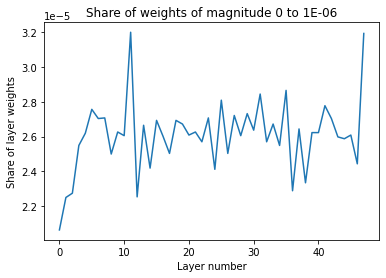

In [37]:
plot_weights_across_layers('0 to 1E-06', layer_results)

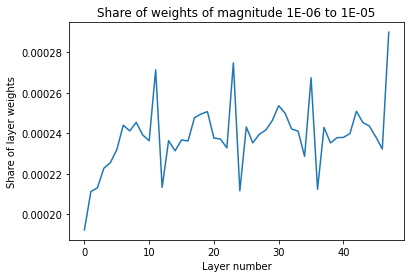

In [38]:
plot_weights_across_layers('1E-06 to 1E-05', layer_results)

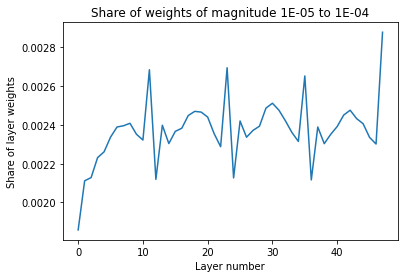

In [39]:
plot_weights_across_layers('1E-05 to 1E-04', layer_results)

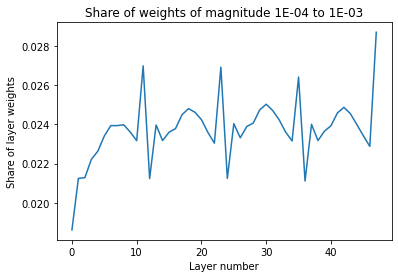

In [40]:
plot_weights_across_layers('1E-04 to 1E-03', layer_results)

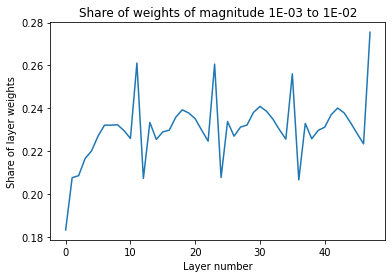

In [41]:
plot_weights_across_layers('1E-03 to 1E-02', layer_results)

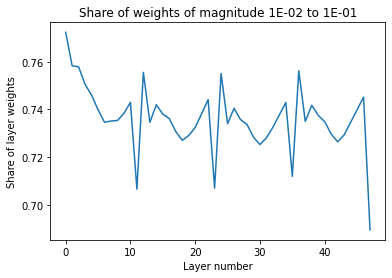

In [42]:
plot_weights_across_layers('1E-02 to 1E-01', layer_results)

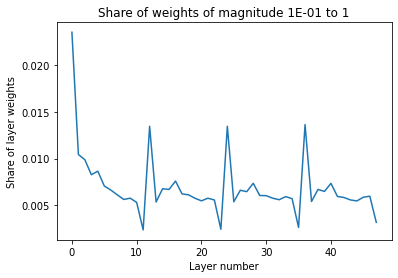

In [43]:
plot_weights_across_layers('1E-01 to 1', layer_results)

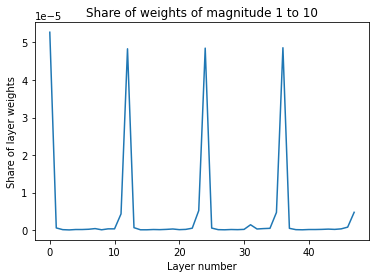

In [44]:
plot_weights_across_layers('1 to 10', layer_results)